write the cplex code for this,

fill an n x n matrix W with random numbers,

define two variable matrices, A and B, with one being n x r • r x n,

optimize for the best r and entries in A and B such that their product contains an approximation of W using some arbitrary loss

In [1]:
import numpy as np
from docplex.cp.model import CpoModel as Model
from docplex.cp.parameters import CpoParameters

n = 32
r = 8


In [2]:
np.random.seed(0)

# myparams = CpoParameters()
m = Model()

W = np.random.rand(n, n).round(6)

A = np.array(m.integer_var_list(r*n, 0, 1000))
B = np.array(m.integer_var_list(n*r, 0, 1000))

for i in range(n*r):
    m.add_constraint(A[i] * B[i] <= 1_000_000)
    m.add_constraint(A[i] * B[i] >= 0)


A_float = np.array([a/1000 for a in A]).reshape(n, r)
B_float = np.array([b/1000 for b in B]).reshape(r, n)

distance = (( (A_float @ B_float) - (W) )**2).sum()

m.minimize(distance)

In [3]:
solution = m.solve(log_output=True, TimeLimit=1200) 
# 0.3136016

CpoSolverException: Solver error: Problem size limit exceeded.
CP Optimizer Community Edition solves problems with search spaces up to 2^1000.
Unrestricted version options (including academia) at https://ibm.co/2s0wqSa


In [ ]:
A_solution = []
B_solution = []

for i in range(n*r):
    A_solution.append(solution[A.tolist()[i]] / 1000)
    B_solution.append(solution[B.tolist()[i]] / 1000)

In [ ]:
W_hat = np.array(A_solution).reshape(n, r) @ np.array(B_solution).reshape(r, n)

In [4]:

((W_hat - W)**2).sum()


NameError: name 'W_hat' is not defined

In [5]:
W_hat

NameError: name 'W_hat' is not defined

In [6]:
W

array([[0.548814, 0.715189, 0.602763, ..., 0.414662, 0.264556, 0.774234],
       [0.45615 , 0.568434, 0.01879 , ..., 0.110375, 0.65633 , 0.138183],
       [0.196582, 0.368725, 0.820993, ..., 0.716327, 0.289406, 0.183191],
       ...,
       [0.77311 , 0.21687 , 0.90315 , ..., 0.522176, 0.853606, 0.889448],
       [0.220104, 0.622894, 0.111496, ..., 0.771225, 0.012171, 0.32283 ],
       [0.229567, 0.506863, 0.736853, ..., 0.6205  , 0.639622, 0.94854 ]])

#### Alternate Solution

In [7]:
np.random.seed(0)
from tqdm import tqdm

n = 64
r = 32
# myparams = CpoParameters()
m = Model()

W = np.random.rand(n, n)
Dupe_count = 32
learning_rate = 0.001
EPOCHS = 100000

all_best_distances = [10e8]

A = [np.random.rand(n, r) for _ in range(Dupe_count)]
B = [np.random.rand(r, n) for _ in range(Dupe_count)]

for i in tqdm(range(EPOCHS)):

    possibles = []

    for a, b in zip(A, B):
        possibles.append(a@b)

    distances =[]
    for idx, poss in enumerate(possibles):
        distances.append(( ((poss) - (W) )**2).sum())


    if np.min(distances) >= np.min(all_best_distances):
        continue

    all_best_distances.append(np.min(distances))

    best_index = np.argmin(distances)

    A_ = [((np.random.rand(n, r)-0.5) * learning_rate) + A[best_index] for _ in range(Dupe_count)]
    B_ = [((np.random.rand(r, n)-0.5) * learning_rate) + B[best_index] for _ in range(Dupe_count)]

    # print(A_)

    A = A_
    B = B_

    lowest_distance = np.min(distances)

    if i % 1000 == 0:
        print(f'Reached Epoch {i} with distance {lowest_distance}')
        learning_rate -= 0.00001

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 10/100000 [00:00<17:26, 95.52it/s]

Reached Epoch 0 with distance 219436.14687874622


  1%|          | 1065/100000 [00:05<05:52, 280.53it/s]

Reached Epoch 1000 with distance 202300.94270223484


  2%|▏         | 2049/100000 [00:08<04:57, 329.72it/s]

Reached Epoch 2000 with distance 186640.92969938318


  3%|▎         | 3052/100000 [00:12<05:39, 285.73it/s]

Reached Epoch 3000 with distance 171953.7845573629


  4%|▍         | 4054/100000 [00:15<04:56, 323.29it/s]

Reached Epoch 4000 with distance 158211.3762179222


  5%|▌         | 5045/100000 [00:18<04:51, 325.73it/s]

Reached Epoch 5000 with distance 145437.00283739477


  6%|▌         | 6034/100000 [00:21<04:53, 319.89it/s]

Reached Epoch 6000 with distance 133476.97662031496


  7%|▋         | 7023/100000 [00:25<07:13, 214.46it/s]

Reached Epoch 7000 with distance 122325.74518069463


  8%|▊         | 7959/100000 [00:29<05:38, 271.85it/s]


KeyboardInterrupt: 

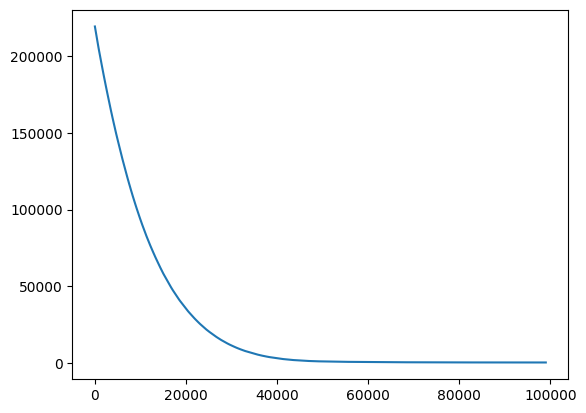

In [34]:
import matplotlib.pyplot as plt
plt.plot(all_best_distances[1:])

In [35]:
all_best_distances[-1]

205.49650823550252

In [36]:
W[:1]

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
        0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
        0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
        0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215,
        0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443,
        0.63992102, 0.14335329, 0.94466892, 0.52184832, 0.41466194,
        0.26455561, 0.77423369, 0.45615033, 0.56843395, 0.0187898 ,
        0.6176355 , 0.61209572, 0.616934  , 0.94374808, 0.6818203 ,
        0.3595079 , 0.43703195, 0.6976312 , 0.06022547, 0.66676672,
        0.67063787, 0.21038256, 0.1289263 , 0.31542835, 0.36371077,
        0.57019677, 0.43860151, 0.98837384, 0.10204481, 0.20887676,
        0.16130952, 0.65310833, 0.2532916 , 0.46631077, 0.24442559,
        0.15896958, 0.11037514, 0.65632959, 0.13818295]])

In [37]:
(A[best_index] @ B[best_index])[:1]

array([[0.44256429, 0.53827876, 0.47480137, 0.61519475, 0.58260742,
        0.56843893, 0.45556814, 0.64610971, 0.77281468, 0.39536792,
        0.51052557, 0.41572843, 0.5553761 , 0.83698542, 0.16370298,
        0.44696992, 0.21374778, 0.74687941, 0.34679602, 0.58910765,
        0.56707936, 0.50925248, 0.50661505, 0.66326411, 0.05034912,
        0.71679844, 0.41421399, 0.52798474, 0.75863155, 0.57991776,
        0.30463705, 0.56892616, 0.44259512, 0.41057791, 0.32003543,
        0.46886895, 0.4089395 , 0.46595273, 0.66987709, 0.53688839,
        0.49296935, 0.64164668, 0.65569185, 0.35627781, 0.48744864,
        0.52200075, 0.54076961, 0.18914343, 0.51702804, 0.41517277,
        0.39479315, 0.55722324, 0.85716223, 0.18230271, 0.3141962 ,
        0.06932318, 0.68103497, 0.41798767, 0.63270966, 0.80774156,
        0.32853918, 0.54547272, 0.91917801, 0.37671129]])

In [ ]:
np.random.seed(0)
from tqdm import tqdm

n = 64
r = 32
# myparams = CpoParameters()
m = Model()

W = np.random.rand(n, n)
Dupe_count = 32
learning_rate = 0.001
EPOCHS = 100000

all_best_distances = [10e8]

A = [np.random.rand(n, r) for _ in range(Dupe_count)]
B = [np.random.rand(r, n) for _ in range(Dupe_count)]

for i in tqdm(range(EPOCHS)):

    possibles = []

    for a, b in zip(A, B):
        possibles.append(a@b)

    distances =[]
    for idx, poss in enumerate(possibles):
        distances.append(( ((poss) - (W) )**2).sum())


    if np.min(distances) >= np.min(all_best_distances):
        continue

    all_best_distances.append(np.min(distances))

    best_index = np.argmin(distances)

    A_ = [((np.random.rand(n, r)-0.5) * learning_rate) + A[best_index] for _ in range(Dupe_count)]
    B_ = [((np.random.rand(r, n)-0.5) * learning_rate) + B[best_index] for _ in range(Dupe_count)]

    # print(A_)

    A = A_
    B = B_

    lowest_distance = np.min(distances)

    if i % 1000 == 0:
        print(f'Reached Epoch {i} with distance {lowest_distance}')
        learning_rate -= 0.00001